#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

#### Loading the data into dataframe from the CSV file

In [4]:
# Reading the CSV file in chunks to manage memory usage
chunk_size = 100  # Load 100 rows at a time
chunks = []
label_counts = {}
csv_file = '../assets/image_dataset/train/tomatoes_dataset.csv'

for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):
    chunks.append(chunk)
    
    # Count labels
    for label in chunk['label'].value_counts().items():
        label_counts[label[0]] = label_counts.get(label[0], 0) + label[1]
    
    if (i + 1) % 10 == 0:
        print(f"Loaded {(i + 1) * chunk_size} rows...")

    if (i + 1) * chunk_size >= 10000:
        break

Loaded 1000 rows...
Loaded 2000 rows...
Loaded 3000 rows...
Loaded 4000 rows...
Loaded 5000 rows...
Loaded 6000 rows...
Loaded 7000 rows...
Loaded 8000 rows...
Loaded 9000 rows...


/tmp/ipykernel_186067/1817967984.py:7: DtypeWarning: Columns (12290) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(csv_file, chunksize=chunk_size)):


Loaded 10000 rows...


In [ ]:
# Combining chunks 
df = pd.concat(chunks, ignore_index=True)
del chunks  # Free memory

print(f"Total tomatoes: {len(df)}")

df.head(1)

Total tomatoes: 10000


,image_name,tomato_id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_12279,pixel_12280,pixel_12281,pixel_12282,pixel_12283,pixel_12284,pixel_12285,pixel_12286,pixel_12287,label
0,001_jpg.rf.5c347afc56aec22b9257d84d363ba621.jpg,0,255,230,220,254,229,219,254,231,...,241,222,219,241,222,219,240,221,218,2


In [6]:
df.shape

(10000, 12291)

#### Sampling the dataset in case it is too large

In [ ]:
sample_size = 10000  # Use 10000 tomatoes
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    df.shape

#### Preparing data for training

In [8]:
# Separate features and labels
X = df.drop(['image_name', 'tomato_id', 'label'], axis=1)
y = df['label']

X.shape

(10000, 12288)

In [9]:

y = y.astype(str).str.replace('class_', '').astype(int)

# Map numeric labels to fresh or rotten
label_mapping = {
    0: 'fresh',      # 0 = very_good
    1: 'fresh',      # 1 = good
    2: 'rotten',     # 2 = bad
    3: 'rotten',     # 3 = very_bad
}

y_binary = y.map(label_mapping)
y_binary.value_counts()

label
rotten    7794
fresh     2205
Name: count, dtype: int64

In [12]:
y_binary.isnull().sum()

# Remove unmapped rows
valid_mask = y_binary.notna()
X = X[valid_mask].reset_index(drop=True)
y_binary = y_binary[valid_mask].reset_index(drop=True)

X.shape, y_binary.shape

((9999, 12288), (9999,))

#### Data preprocessing

###### Handling missing and infinite values

In [13]:
# Check for missing values 
X.isnull().sum().sum()
# replace missing values with 0
X.fillna(0, inplace=True)

# Check for infinite values
np.isinf(X.values).sum()
# replace infinite values with 0
X.replace([np.inf, -np.inf], 0, inplace=True)

###### Normalize the pixel values from 0-255 to 0-1

In [14]:
X_normalized = X / 255.0

np.isnan(X_normalized.values).sum()
X_normalized = X_normalized.fillna(0)

###### Standardization

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_normalized)
X_scaled.shape

np.isnan(X_scaled).sum()
np.isinf(X_scaled).sum()

X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

###### Check for constant features

In [16]:
feature_variance = np.var(X_scaled, axis=0)
n_constant = np.sum(feature_variance == 0)

non_constant_mask = feature_variance > 0
X_scaled = X_scaled[:, non_constant_mask]

X_scaled.shape

(9999, 12288)

###### PCA

In [17]:
# Choose number of components
n_components = min(50, X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Final check for NaN/Inf
np.isnan(X_pca).sum()
np.isinf(X_pca).sum()

X_pca = np.nan_to_num(X_pca, nan=0.0, posinf=0.0, neginf=0.0)


X_pca.shape

(9999, 50)

#### SPLIT DATA (Train/Test)

In [18]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7999
Test set size: 2000


#### TRAIN K-MEANS MODEL

In [19]:
# Since we have 2 categories (fresh/rotten), we use k=2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
kmeans.fit(X_train)

print("Training complete!")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")

Training complete!
Cluster centers shape: (2, 50)
Inertia (within-cluster sum of squares): 60572281.37


#### MAP CLUSTERS TO LABELS

In [20]:
# Predict clusters for training data
train_clusters = kmeans.predict(X_train)

# Find which cluster corresponds to which label
cluster_label_mapping = {}
for cluster_id in range(k):
    mask = train_clusters == cluster_id
    labels_in_cluster = y_train[mask]
    
    if len(labels_in_cluster) > 0:
        most_common = labels_in_cluster.mode()[0]
        cluster_label_mapping[cluster_id] = most_common
        
        print(f"\nCluster {cluster_id}:")
        print(labels_in_cluster.value_counts())
        print(f"  -> Mapped to: {most_common}")
    else:
        print(f"\nCluster {cluster_id}: EMPTY")
        cluster_label_mapping[cluster_id] = 'unknown'

print(f"\nFinal mapping: {cluster_label_mapping}")


Cluster 0:
label
rotten    3253
fresh      946
Name: count, dtype: int64
  -> Mapped to: rotten

Cluster 1:
label
rotten    2982
fresh      818
Name: count, dtype: int64
  -> Mapped to: rotten

Final mapping: {0: 'rotten', 1: 'rotten'}


#### MAKE PREDICTIONS

In [22]:
# Predict on training set
train_cluster_pred = kmeans.predict(X_train)
y_train_pred = pd.Series([cluster_label_mapping[c] for c in train_cluster_pred])

# Predict on test set
test_cluster_pred = kmeans.predict(X_test)
y_test_pred = pd.Series([cluster_label_mapping[c] for c in test_cluster_pred])

#### EVALUATE MODEL

In [23]:

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['fresh', 'rotten'])
print(cm)

Training Accuracy: 0.7795 (77.95%)
Test Accuracy: 0.7795 (77.95%)
              precision    recall  f1-score   support

       fresh       0.00      0.00      0.00       441
      rotten       0.78      1.00      0.88      1559

    accuracy                           0.78      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.61      0.78      0.68      2000

[[   0  441]
 [   0 1559]]


/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

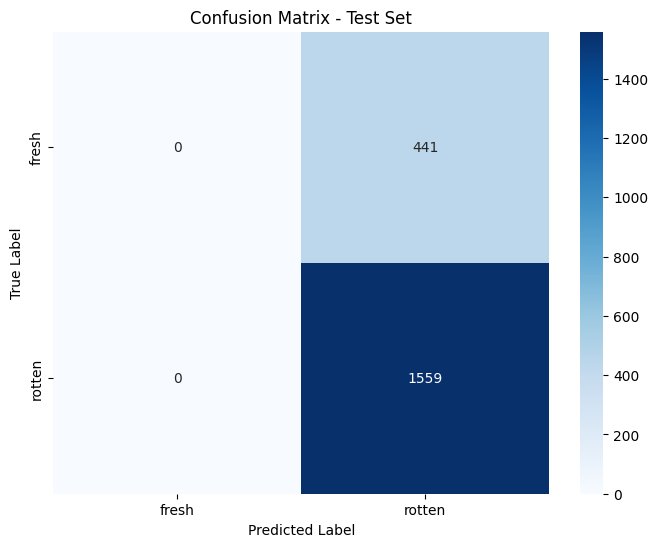

In [24]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['fresh', 'rotten'], 
            yticklabels=['fresh', 'rotten'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### VISUALIZE CLUSTERS

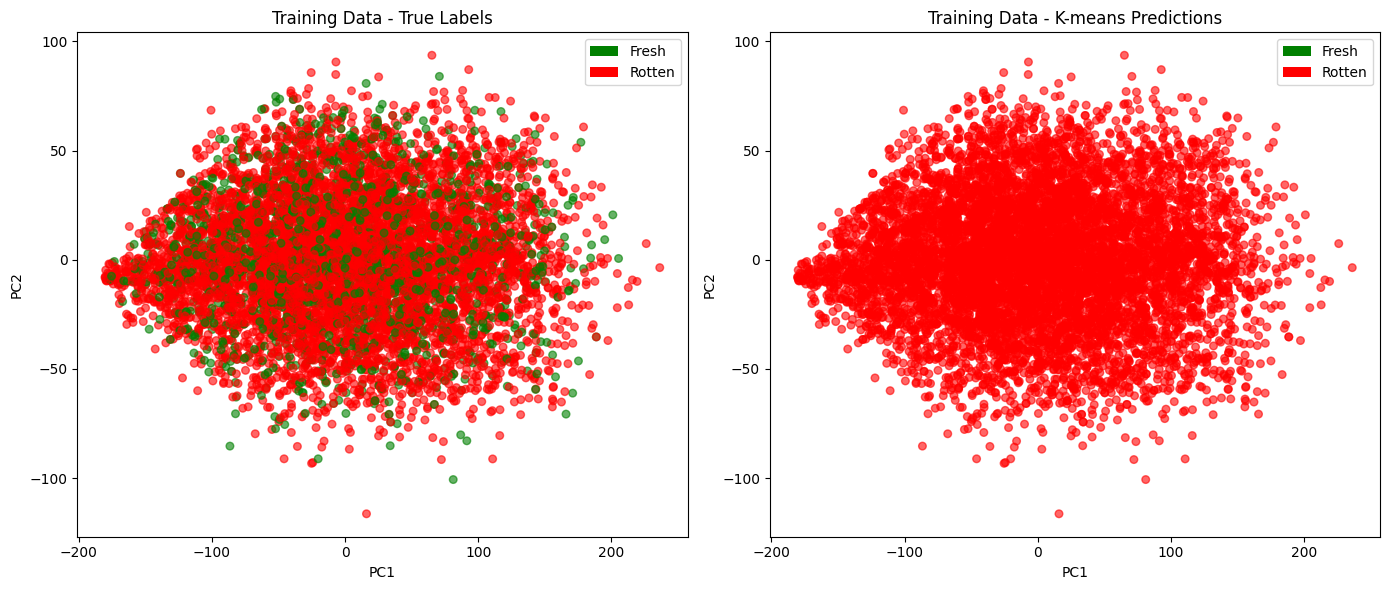

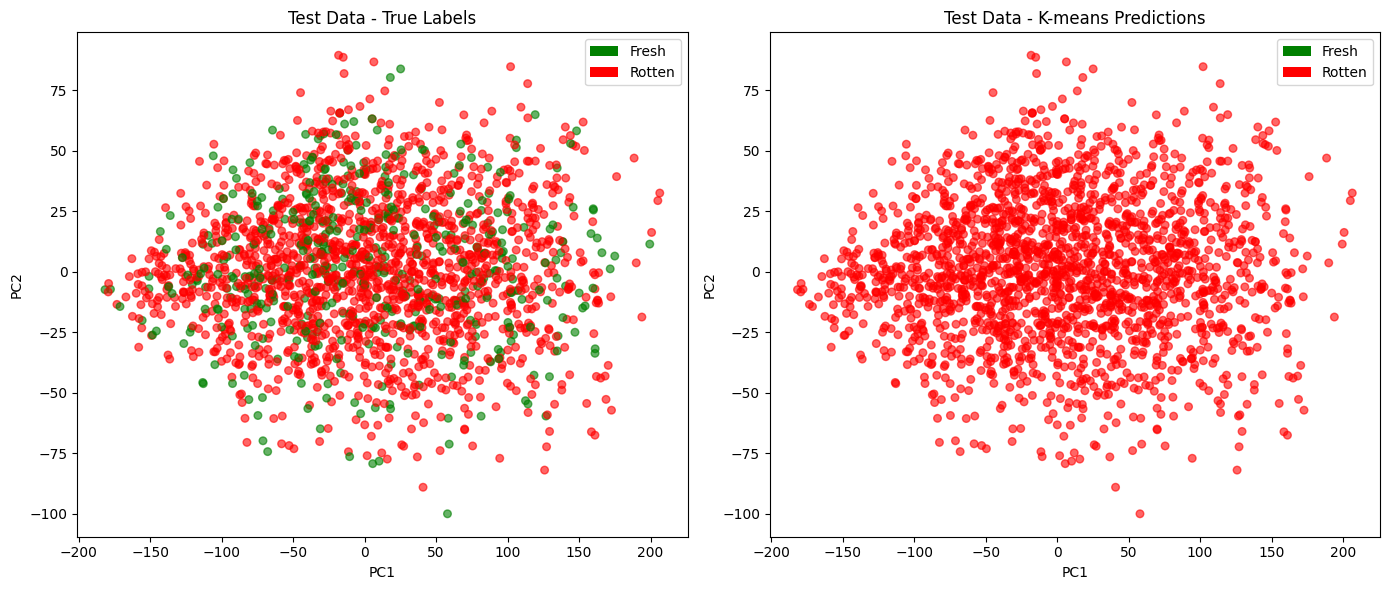

In [25]:
# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)

# Plot training data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['green' if label == 'fresh' else 'red' for label in y_train]
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=colors, alpha=0.6, s=30)
plt.title('Training Data - True Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Fresh'),
                   Patch(facecolor='red', label='Rotten')]
plt.legend(handles=legend_elements)

plt.subplot(1, 2, 2)
colors_pred = ['green' if label == 'fresh' else 'red' for label in y_train_pred]
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=colors_pred, alpha=0.6, s=30)
plt.title('Training Data - K-means Predictions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Plot test data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['green' if label == 'fresh' else 'red' for label in y_test]
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors, alpha=0.6, s=30)
plt.title('Test Data - True Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.subplot(1, 2, 2)
colors_pred = ['green' if label == 'fresh' else 'red' for label in y_test_pred]
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=colors_pred, alpha=0.6, s=30)
plt.title('Test Data - K-means Predictions')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

##### k-means visualization 

Training K-Means and tracking inertia...


Converged at iteration 13


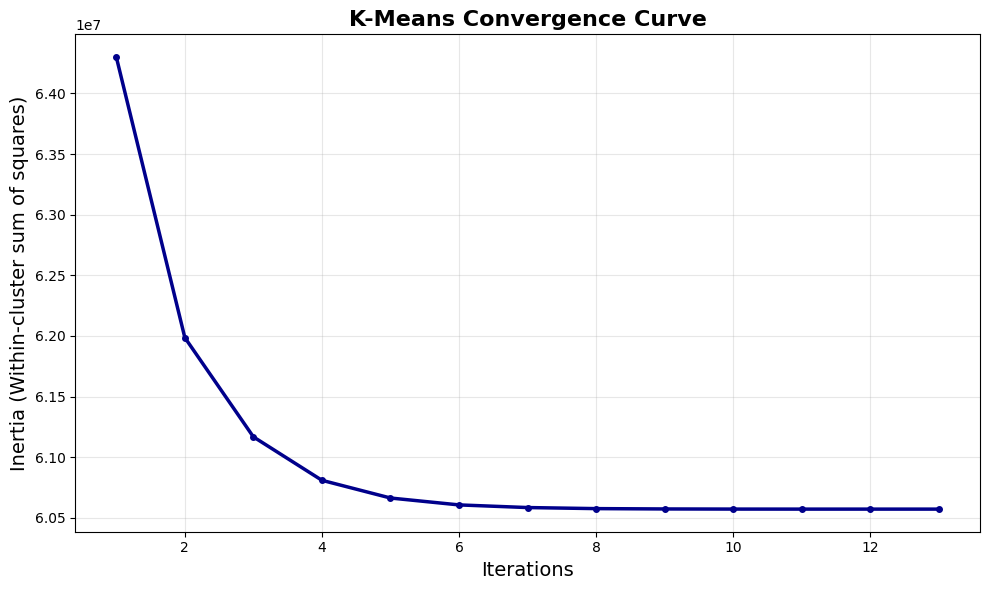


Final Inertia: 60572285.71
Total Iterations: 13

Elbow Method - Finding Optimal Number of Clusters


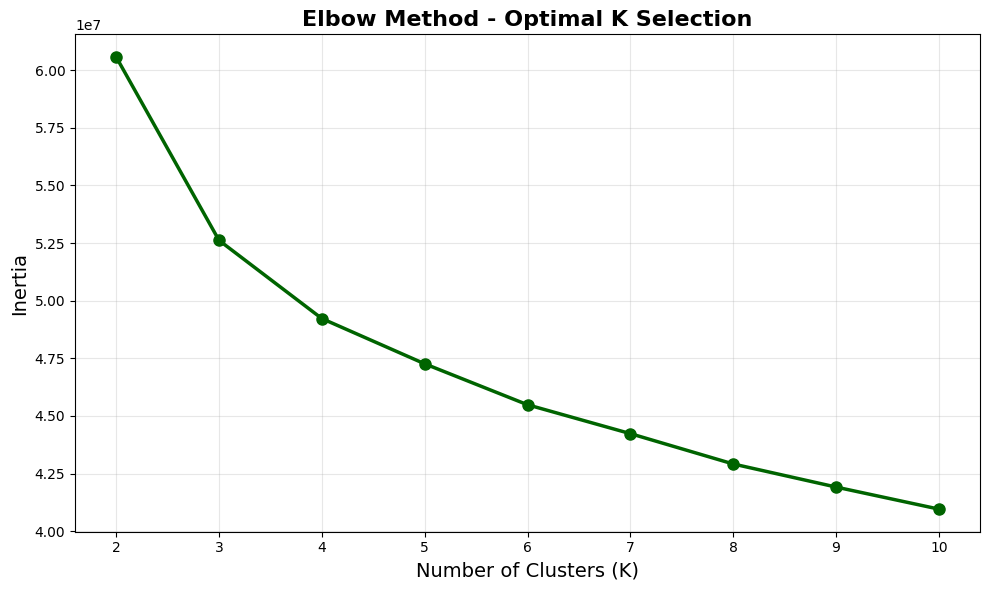


Inertia values for different K:
K = 2: Inertia = 60572285.71
K = 3: Inertia = 52616907.35
K = 4: Inertia = 49224716.27
K = 5: Inertia = 47261524.31
K = 6: Inertia = 45485317.06
K = 7: Inertia = 44232677.82
K = 8: Inertia = 42916847.81
K = 9: Inertia = 41915700.99
K = 10: Inertia = 40958616.28

Silhouette Score Analysis


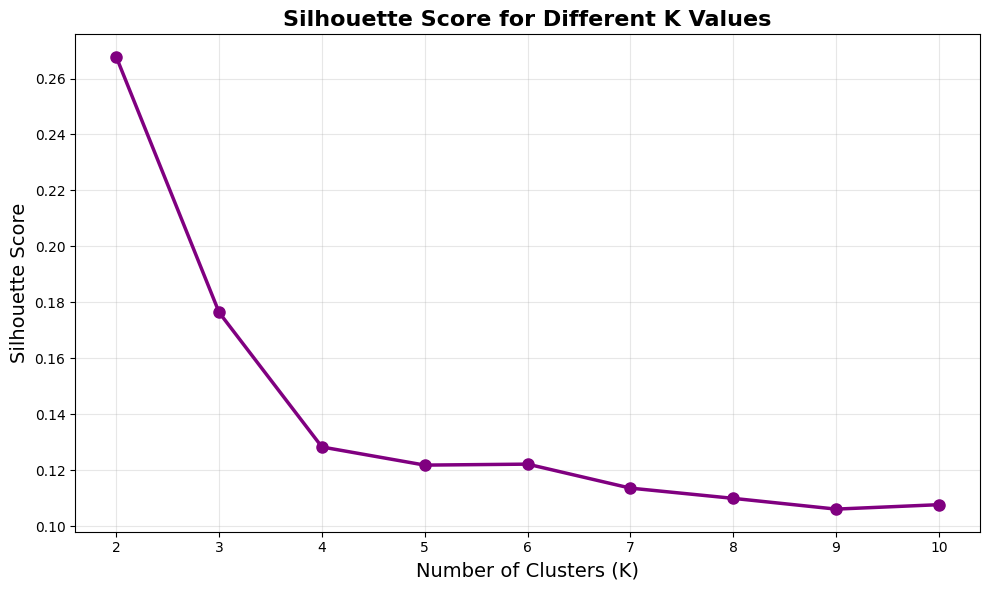


Silhouette scores for different K:
K = 2: Silhouette Score = 0.2677
K = 3: Silhouette Score = 0.1764
K = 4: Silhouette Score = 0.1283
K = 5: Silhouette Score = 0.1218
K = 6: Silhouette Score = 0.1221
K = 7: Silhouette Score = 0.1136
K = 8: Silhouette Score = 0.1099
K = 9: Silhouette Score = 0.1061
K = 10: Silhouette Score = 0.1076

✓ Best K based on Silhouette Score: 2


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# ============================================
# METHOD 1: Track Inertia During Training
# ============================================
print("Training K-Means and tracking inertia...")

# Initialize KMeans with max_iter=1 and warm_start simulation
n_clusters = 2 
max_iterations = 100

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, max_iter=1)

inertia_values = []
iterations = []

# Manually track inertia at each iteration
X_data = X_train 

for i in range(1, max_iterations + 1):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', 
                    random_state=42, max_iter=i, n_init=1)
    kmeans.fit(X_data)
    
    inertia_values.append(kmeans.inertia_)
    iterations.append(i)
    
    # Check convergence
    if i > 2 and abs(inertia_values[-1] - inertia_values[-2]) < 1e-4:
        print(f"Converged at iteration {i}")
        break

# Plot Inertia Curve
plt.figure(figsize=(10, 6))
plt.plot(iterations, inertia_values, linewidth=2.5, color='darkblue', marker='o', markersize=4)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=14)
plt.title('K-Means Convergence Curve', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal Inertia: {inertia_values[-1]:.2f}")
print(f"Total Iterations: {len(iterations)}")


# ============================================
# METHOD 2: Elbow Method (Finding Optimal K)
# ============================================
print("\n" + "="*50)
print("Elbow Method - Finding Optimal Number of Clusters")
print("="*50)

inertias = []
K_range = range(2, 11)  # Test K from 2 to 10

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=300)
    kmeans_temp.fit(X_data)
    inertias.append(kmeans_temp.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, linewidth=2.5, color='darkgreen', marker='o', markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method - Optimal K Selection', fontsize=16, fontweight='bold')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInertia values for different K:")
for k, inertia in zip(K_range, inertias):
    print(f"K = {k}: Inertia = {inertia:.2f}")


# ============================================
# METHOD 3: Silhouette Score (Better Metric)
# ============================================
from sklearn.metrics import silhouette_score

print("\n" + "="*50)
print("Silhouette Score Analysis")
print("="*50)

silhouette_scores = []

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=300)
    labels = kmeans_temp.fit_predict(X_data)
    score = silhouette_score(X_data, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, linewidth=2.5, color='purple', marker='o', markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score for Different K Values', fontsize=16, fontweight='bold')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSilhouette scores for different K:")
for k, score in zip(K_range, silhouette_scores):
    print(f"K = {k}: Silhouette Score = {score:.4f}")

best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Best K based on Silhouette Score: {best_k}")

#### Logistic Regression Model

In [41]:
model = LogisticRegression(C=0.1, penalty='l2',max_iter=3000, solver='lbfgs', verbose=1)
    
model.fit(X_train, y_train)
print("   Training complete.")

   Training complete.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [42]:
y_pred = model.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"FINAL ACCURACY: {acc * 100:.2f}%")

FINAL ACCURACY: 77.95%


In [35]:
# clasification report
report = classification_report(y_test, y_pred, target_names=['Fresh (0)', 'Rotten (1)'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   Fresh (0)       0.00      0.00      0.00       441
  Rotten (1)       0.78      1.00      0.88      1559

    accuracy                           0.78      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.61      0.78      0.68      2000



/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1).
You might also want to scale the data as shown in:
    htt

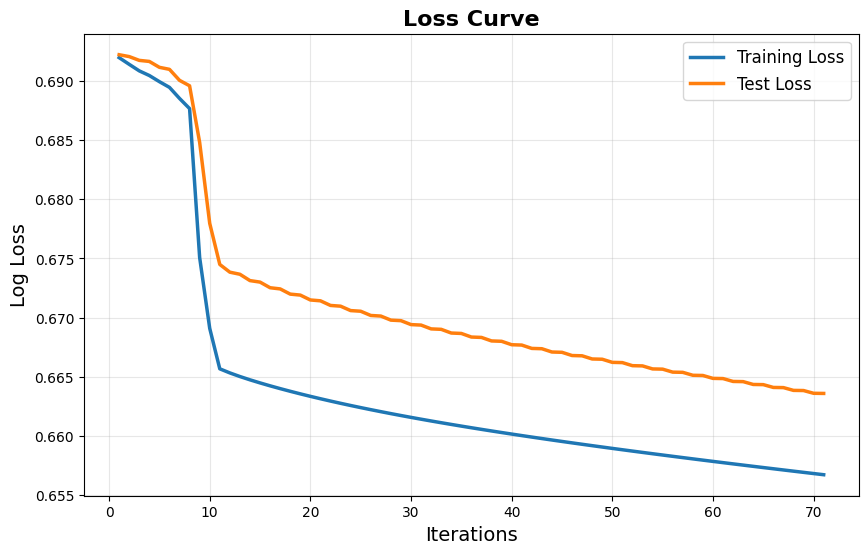

Final Training Loss: 0.6567
Final Test Loss: 0.6636


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# Track loss during training
train_losses = []
test_losses = []

# Retrain with warm_start to track loss at each iteration
model_loss = LogisticRegression(C=0.1, penalty='l2', max_iter=1, warm_start=True, solver='lbfgs', verbose=0)

for i in range(1, 501):
    model_loss.fit(X_train, y_train)
    
    train_loss = log_loss(y_train, model_loss.predict_proba(X_train))
    test_loss = log_loss(y_test, model_loss.predict_proba(X_test))
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if i > 10 and abs(train_losses[-1] - train_losses[-2]) < 1e-4:
        break

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', linewidth=2.5)
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss', linewidth=2.5)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Loss Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

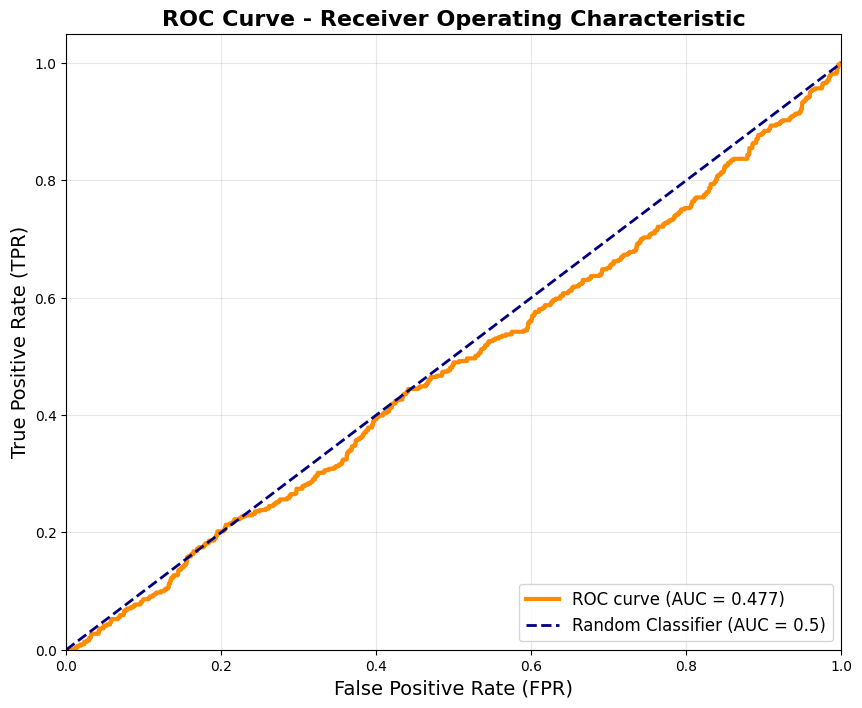

AUC Score: 0.4766

Interpretation:
Very poor model (AUC < 0.6)


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve (specify pos_label for string labels)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='fresh')

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve - Receiver Operating Characteristic', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")
print(f"\nInterpretation:")
if roc_auc >= 0.9:
    print("Excellent model (AUC ≥ 0.9)")
elif roc_auc >= 0.8:
    print("Good model (0.8 ≤ AUC < 0.9)")
elif roc_auc >= 0.7:
    print("Fair model (0.7 ≤ AUC < 0.8)")
elif roc_auc >= 0.6:
    print("Poor model (0.6 ≤ AUC < 0.7)")
else:
    print("Very poor model (AUC < 0.6)")

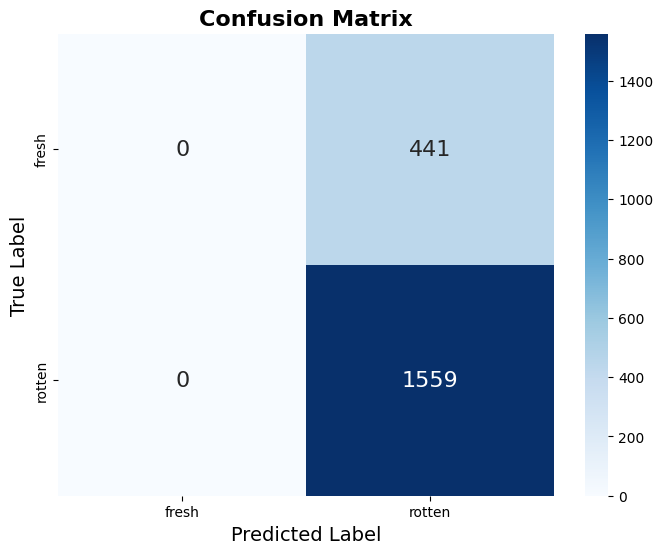


Confusion Matrix:
[[   0  441]
 [   0 1559]]

Classification Report:
              precision    recall  f1-score   support

       fresh       0.00      0.00      0.00       441
      rotten       0.78      1.00      0.88      1559

    accuracy                           0.78      2000
   macro avg       0.39      0.50      0.44      2000
weighted avg       0.61      0.78      0.68      2000


Detailed Metrics:
True Negatives (TN):  0
False Positives (FP): 441
False Negatives (FN): 0
True Positives (TP):  1559

Accuracy:  0.7795
Precision: 0.7795
Recall:    1.0000
F1-Score:  0.8761


/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ahmed/Work/Ahmed/ThirdYear/Cs/ML/project/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['fresh', 'rotten'], 
            yticklabels=['fresh', 'rotten'],
            annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

# Print detailed metrics
print("\nConfusion Matrix:")
print(cm)
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred))

# Calculate and print individual metrics
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*50)
print("Detailed Metrics:")
print("="*50)
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nAccuracy:  {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall:    {tp / (tp + fn):.4f}")
print(f"F1-Score:  {2 * tp / (2 * tp + fp + fn):.4f}")